# Diabetes Data Mining Project (Milestone 1)

This notebook is refactored from `Project.py` into clear, modular steps.

It includes:
- Data loading and inspection  
- Outlier detection and handling (mask + median imputation)  
- Categorical cleaning and encoding  
- Scaling and visualization (boxplots, scatter plots, correlations)



In [1]:
# --- 1) Setup & Imports ---

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, minmax_scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics

## Step 1: Load and Inspect the Dataset


In [2]:
df=pd.read_csv("Dataset_Diabetes.csv")

#Step 1: Understanding the dataset
#print(df.head())
print(df.info())
#print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         1000 non-null   int64  
 1   No_Pation  1000 non-null   int64  
 2   Gender     1000 non-null   object 
 3   AGE        1000 non-null   int64  
 4   Urea       1000 non-null   float64
 5   Cr         1000 non-null   int64  
 6   HbA1c      1000 non-null   float64
 7   Chol       1000 non-null   float64
 8   TG         1000 non-null   float64
 9   HDL        1000 non-null   float64
 10  LDL        1000 non-null   float64
 11  VLDL       1000 non-null   float64
 12  BMI        1000 non-null   float64
 13  CLASS      1000 non-null   object 
dtypes: float64(8), int64(4), object(2)
memory usage: 109.5+ KB
None


## Step 2–3: Check for Missing Values and Duplicates


In [3]:
#Step2: Null
#check for null values even though df.info confirmed there arent any
print(df.isnull().sum())
#Step3: Duplicates
#check for duplicated rows
print(df.duplicated().sum())


ID           0
No_Pation    0
Gender       0
AGE          0
Urea         0
Cr           0
HbA1c        0
Chol         0
TG           0
HDL          0
LDL          0
VLDL         0
BMI          0
CLASS        0
dtype: int64
0


## Step 4: Handle Categorical Columns (Class & Gender)


In [4]:
#Step4: Categorical Columns (Class & Gender)
cat_col=df.select_dtypes(include = 'object').columns
print (cat_col)

for col in cat_col:
    print(df[col].unique())

df['Gender'] = df['Gender'].replace({'f':'F'})
df['CLASS'] = df['CLASS'].replace({'N ':'N','Y ':'Y'})

for col in cat_col:
    print(df[col].unique())

#now we have consistent values
#label encode Gender
gender_encoder= LabelEncoder()
df['Gender_encoded']=gender_encoder.fit_transform(df['Gender'])
#One hot encode Class
df['CLASS_original'] = df['CLASS']  # Save before one-hot encoding
df = pd.get_dummies(df, columns=['CLASS'], prefix='Class', dtype=int)

#print(df)


Index(['Gender', 'CLASS'], dtype='object')
['F' 'M' 'f']
['N' 'N ' 'P' 'Y' 'Y ']
['F' 'M']
['N' 'P' 'Y']


In [5]:
print(df.head())

    ID  No_Pation Gender  AGE  Urea  Cr  HbA1c  Chol   TG  HDL  LDL  VLDL  \
0  502      17975      F   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5   
1  735      34221      M   26   4.5  62    4.9   3.7  1.4  1.1  2.1   0.6   
2  420      47975      F   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5   
3  680      87656      F   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5   
4  504      34223      M   33   7.1  46    4.9   4.9  1.0  0.8  2.0   0.4   

    BMI  Gender_encoded CLASS_original  Class_N  Class_P  Class_Y  
0  24.0               0              N        1        0        0  
1  23.0               1              N        1        0        0  
2  24.0               0              N        1        0        0  
3  24.0               0              N        1        0        0  
4  21.0               1              N        1        0        0  


## Step 5: Data Visualization

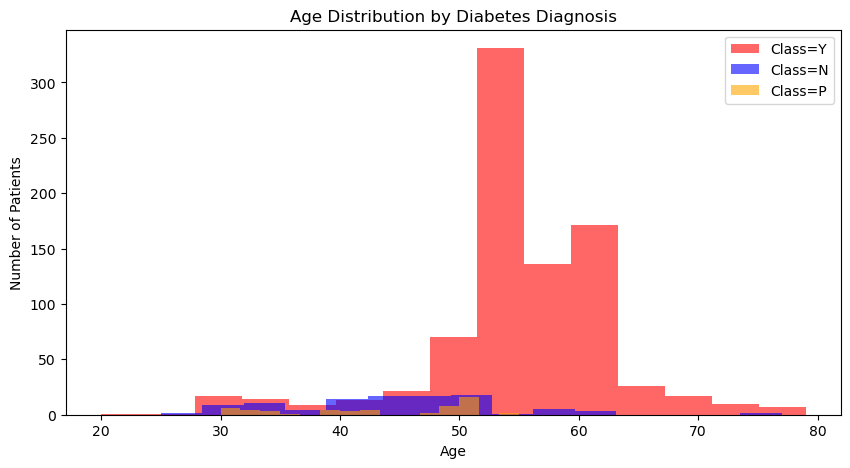

Percent of young diagnosed: 47.73%
Percent of young diagnosed out of the total diagnosed: 4.98%


In [6]:
#visualization
#Age distribution of diagnosis classes
plt.figure(figsize=(10,5))
for dclass, color in zip(['Y','N','P'],['red','blue','orange']):
    subset = df[df['CLASS_original']==dclass]
    plt.hist(subset['AGE'], bins=15, alpha=0.6, label=f'Class={dclass}', color=color)
plt.xlabel('Age')
plt.ylabel('Number of Patients')
plt.title('Age Distribution by Diabetes Diagnosis')
plt.legend()
plt.show()

# What percentage of younger people are prone to be diagnosed with diabetes disease? 
young_cutoff = 40
young = df[df['AGE'] < young_cutoff] #total count of "young" people
young_diabetes = young[young['CLASS_original']=='Y'] # how many of them are diagnosed
percent_young_diabetes = len(young_diabetes) / len(young) * 100 if len(young) > 0 else None
print(f'Percent of young diagnosed: {percent_young_diabetes:.2f}%')

# how many of the total diagnosed people are considered young?
total_diagnosed = df[df['CLASS_original']=='Y']
percent_young = len(young_diabetes) / len(total_diagnosed) * 100 if len(young) > 0 else None
print(f'Percent of young diagnosed out of the total diagnosed: {percent_young:.2f}%')

CLASS_original   N   P    Y
Gender                     
F               64  17  354
M               39  36  490
percentage of females out of the total diagnosed 41.94%
percentage of males out of the total diagnosed 58.06%


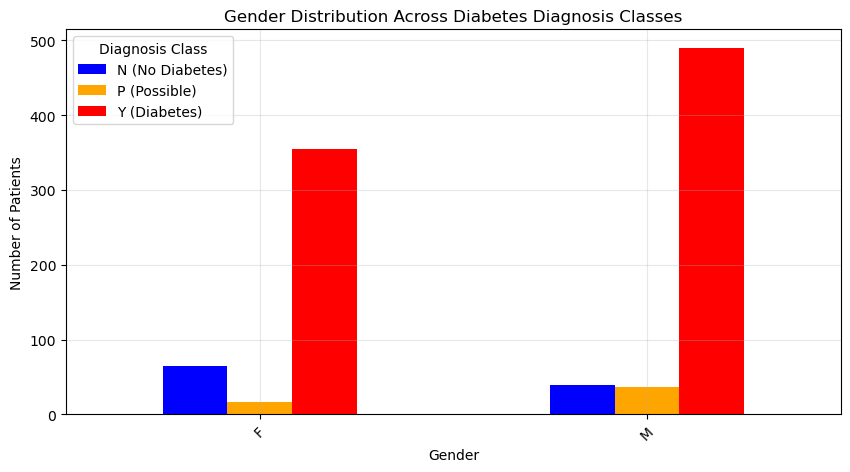

In [7]:
# Group by gender and class to find out which gender is more prone to diabetes
gender_counts = df.groupby(['Gender', 'CLASS_original']).size().unstack(fill_value=0)
print(gender_counts)

# in percentage:
female_diagnosed_percent = len(df.query("CLASS_original== 'Y' and Gender == 'F'")) / len(total_diagnosed) * 100
male_diagnosed_percent = len(df.query("CLASS_original == 'Y' and Gender == 'M'")) / len(total_diagnosed) * 100
print(f'percentage of females out of the total diagnosed {female_diagnosed_percent:.2f}%')
print(f'percentage of males out of the total diagnosed {male_diagnosed_percent:.2f}%')

# Create a grouped bar chart
gender_counts.plot(kind='bar', figsize=(10, 5), color=['blue', 'orange', 'red'])
plt.title('Gender Distribution Across Diabetes Diagnosis Classes')
plt.xlabel('Gender')
plt.ylabel('Number of Patients')
plt.legend(title='Diagnosis Class', labels=['N (No Diabetes)', 'P (Possible)', 'Y (Diabetes)'])
plt.xticks(rotation=45)
plt.grid(alpha=0.3)  # Light grid
plt.show()

## Step 6: Select Numeric Columns for Outlier Detection


In [8]:
#drop id and number of patients because they will distort the results
num_col=df.select_dtypes(exclude='object').columns.drop(['ID', 'No_Pation','Gender_encoded','Class_N','Class_P','Class_Y'])
print (num_col)


Index(['AGE', 'Urea', 'Cr', 'HbA1c', 'Chol', 'TG', 'HDL', 'LDL', 'VLDL',
       'BMI'],
      dtype='object')


## Step 7: Outlier Detection using IQR


In [9]:
#now we check for outliers
q1= df[num_col].quantile(0.25)
q3 = df[num_col].quantile(0.75)
iqr= q3-q1

outlier_mask = (df[num_col] < (q1 - 1.5 * iqr)) | (df[num_col] > (q3 + 1.5 * iqr))

outlier_counts = outlier_mask.sum()
print(outlier_counts)
# Detect rows where ANY column is an outlier
row_outlier_mask = outlier_mask.any(axis=1)

# Total number of outlier rows
outlier_count = row_outlier_mask.sum()

print(outlier_count)


AGE      98
Urea     65
Cr       52
HbA1c     6
Chol     27
TG       55
HDL      50
LDL      11
VLDL     74
BMI       3
dtype: int64
321


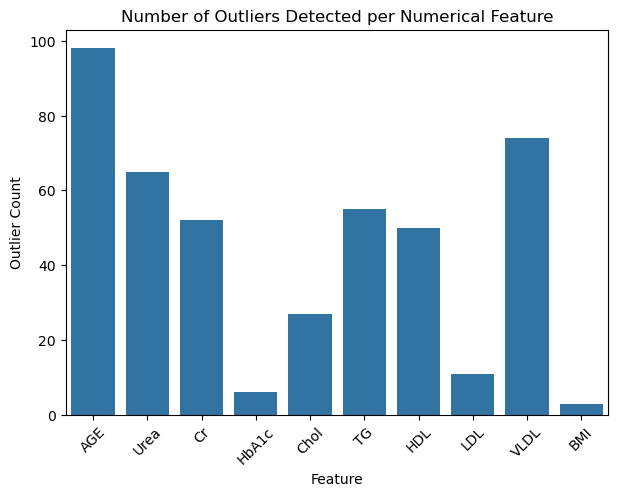

In [10]:
# --- Bar Plot of Outlier Counts ---
plt.figure(figsize=(7, 5))
sns.barplot(x=outlier_counts.index, y=outlier_counts.values)
plt.title("Number of Outliers Detected per Numerical Feature")
plt.ylabel("Outlier Count")
plt.xlabel("Feature")
plt.xticks(rotation=45)
plt.show()

## Step 8: Visualize Outliers (Before Cleaning)


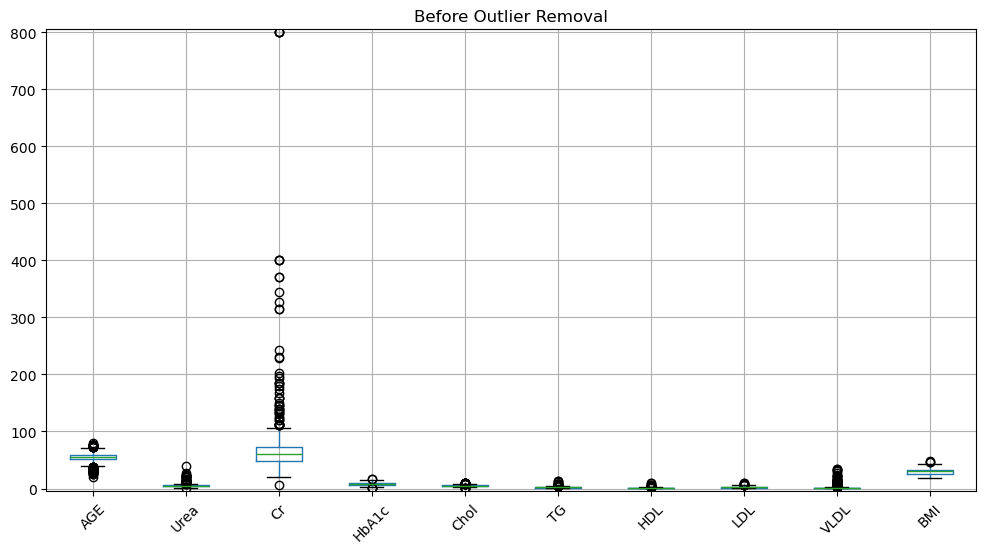

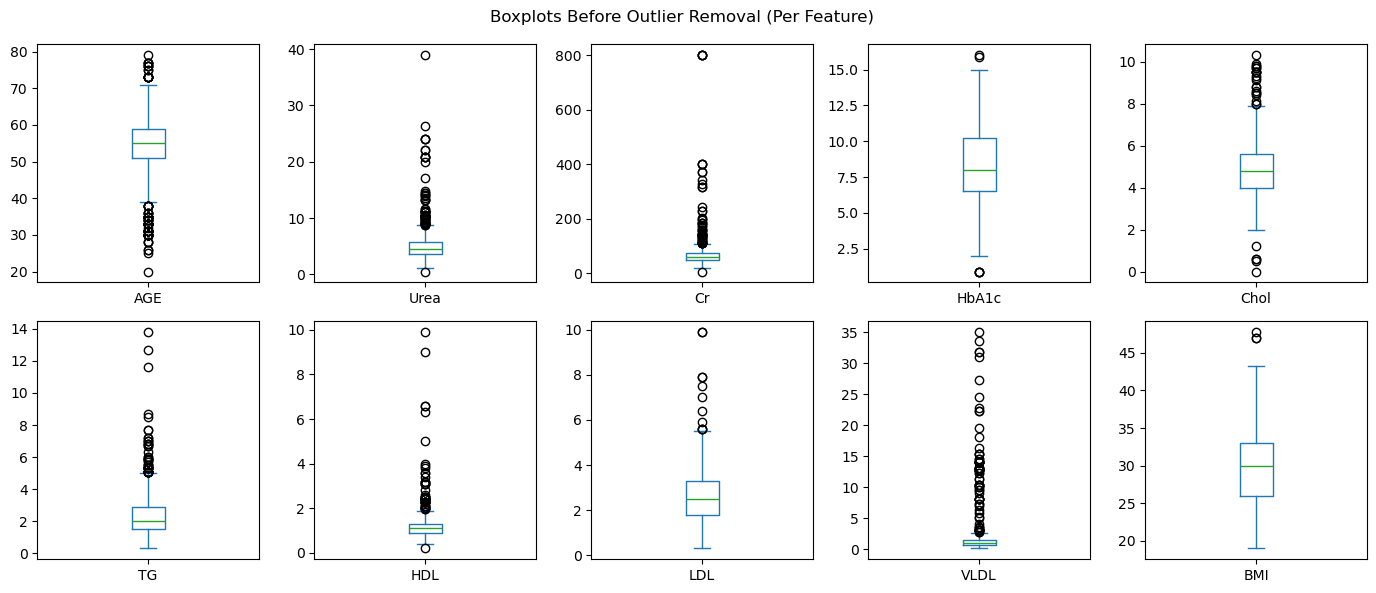

In [11]:
#visualizing the outliers

# Get global min and max from the original (before cleaning) DataFrame
ymin = df[num_col].min().min() -5
ymax = df[num_col].max().max() + 5

# --- Before removing outliers ---
plt.figure(figsize=(12,6))
df[num_col].boxplot()
plt.title("Before Outlier Removal")
plt.ylim(ymin, ymax)  # fix y scale
plt.xticks(rotation=45)
plt.savefig("visualization/Boxplot_before_outlier_removal.png", dpi=300, bbox_inches='tight')
plt.show()

# --- Individual boxplots per feature (grid layout like after cleaning) ---
ax = df[num_col].plot.box(
    subplots=True,
    layout=(2, 5),            # Adjust depending on number of numeric features
    figsize=(14, 6),
    sharey=False,
    title="Boxplots Before Outlier Removal (Per Feature)"
)

plt.tight_layout()
plt.savefig("visualization/Boxplot_before_outlier_removal_subplots.png", dpi=300, bbox_inches='tight')
plt.show()


## Step 9: Mask and Impute Outliers


In [12]:
# df_cleaned = df[~outlier_mask.any(axis=1)]

#Mask outlier cells with NaN (ensure dtype can hold NaN)
df_masked = df.copy()

# Force ALL numeric feature columns to float64 so NaN is allowed (prevents FutureWarning)
df_masked = df_masked.astype({col: "float64" for col in num_col})

# Now it’s safe to insert NaN via mask
df_masked.loc[:, num_col] = df_masked.loc[:, num_col].mask(outlier_mask)

#Impute missing values (from outlier masking) with median
imputer = SimpleImputer(strategy="median")
imputed_values = imputer.fit_transform(df_masked[num_col])  # returns float64 array

df_cleaned = df_masked.copy()
df_cleaned.loc[:, num_col] = imputed_values


## Step 10: Evaluate Outlier Masking and Imputation


In [13]:
#######################################EVALUTAING OUTLIER MASKING AND IMPUTATION#######################################

#how many outliers were there
total_outliers = outlier_mask.sum().sum()
print(f"\nTotal outlier cells detected: {total_outliers}")
print(outlier_mask.sum().sort_values(ascending=False))

#how many NaNs introduced before imputation
print("\nNaNs introduced (before imputation):")
print(df_masked[num_col].isna().sum().sort_values(ascending=False))

#Check that imputation removed all NaNs
print("\nRemaining NaNs after imputation (should be 0):")
print(df_cleaned[num_col].isna().sum().sum())

# Check medians didn’t shift wildly
print(pd.DataFrame({
    'Median_before': df[num_col].median().round(3),
    'Median_after' : df_cleaned[num_col].median().round(3)
}))

#check means didn’t shift wildly
print(pd.DataFrame({
    'Mean_before': df[num_col].mean().round(3),
    'Mean_after' : df_cleaned[num_col].mean().round(3)
}))



Total outlier cells detected: 441
AGE      98
VLDL     74
Urea     65
TG       55
Cr       52
HDL      50
Chol     27
LDL      11
HbA1c     6
BMI       3
dtype: int64

NaNs introduced (before imputation):
AGE      98
VLDL     74
Urea     65
TG       55
Cr       52
HDL      50
Chol     27
LDL      11
HbA1c     6
BMI       3
dtype: int64

Remaining NaNs after imputation (should be 0):
0
       Median_before  Median_after
AGE             55.0          55.0
Urea             4.6           4.5
Cr              60.0          59.0
HbA1c            8.0           8.0
Chol             4.8           4.8
TG               2.0           2.0
HDL              1.1           1.1
LDL              2.5           2.5
VLDL             0.9           0.9
BMI             30.0          30.0
       Mean_before  Mean_after
AGE         53.528      54.946
Urea         5.125       4.562
Cr          68.943      59.767
HbA1c        8.281       8.294
Chol         4.863       4.789
TG           2.350       2.116
HDL      

## Step 11: Scatter Plots Before Outlier Removal


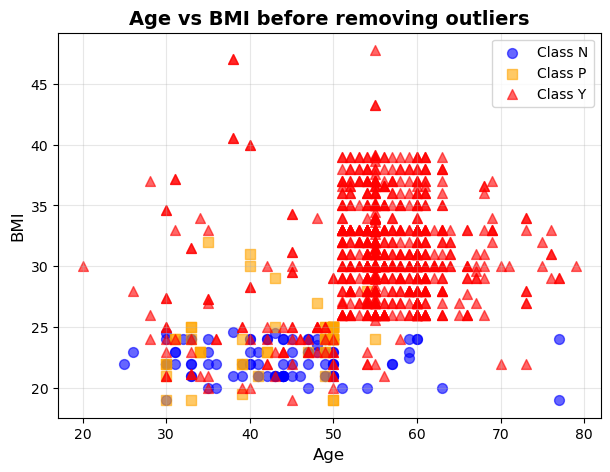

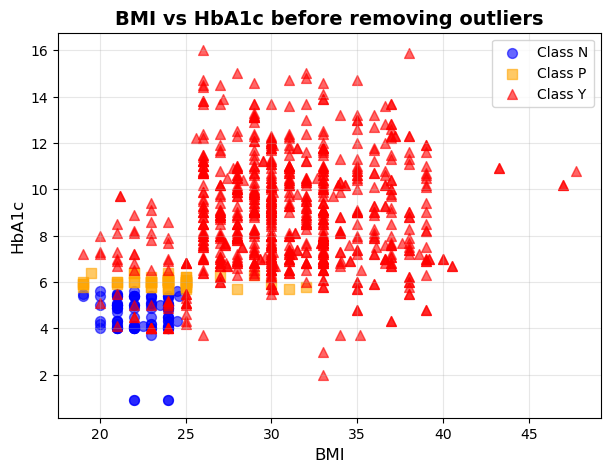

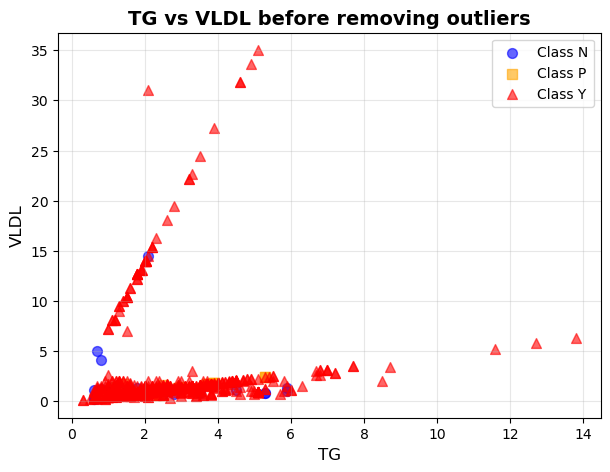

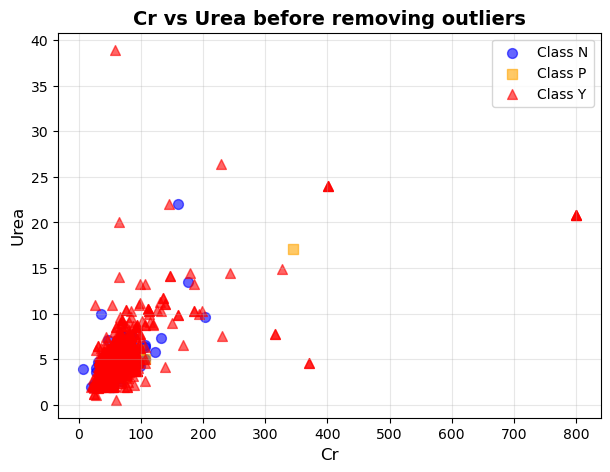

In [14]:
#######################################Scatter plots before removing outliers#######################################
plt.figure(figsize=(7, 5))
for dclass, color, marker in zip(['N', 'P', 'Y'], ['blue', 'orange', 'red'], ['o', 's', '^']):
    subset = df[df['CLASS_original'] == dclass]
    plt.scatter(subset['AGE'], subset['BMI'],
                alpha=0.6, c=color, label=f'Class {dclass}', marker=marker, s=50)

plt.xlabel('Age', fontsize=12)
plt.ylabel('BMI', fontsize=12)
plt.title('Age vs BMI before removing outliers', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("visualization/Age_vs_BMI_before_outliers.png", dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(7, 5))
for dclass, color, marker in zip(['N', 'P', 'Y'], ['blue', 'orange', 'red'], ['o', 's', '^']):
    subset = df[df['CLASS_original'] == dclass]
    plt.scatter(subset['BMI'], subset['HbA1c'],
                alpha=0.6, c=color, label=f'Class {dclass}', marker=marker, s=50)

plt.xlabel('BMI', fontsize=12)
plt.ylabel('HbA1c', fontsize=12)
plt.title('BMI vs HbA1c before removing outliers', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("visualization/BMI_vs_HbA1c_before_outliers.png", dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(7, 5))
for dclass, color, marker in zip(['N', 'P', 'Y'], ['blue', 'orange', 'red'], ['o', 's', '^']):
    subset = df[df['CLASS_original'] == dclass]
    plt.scatter(subset['TG'], subset['VLDL'],
                alpha=0.6, c=color, label=f'Class {dclass}', marker=marker, s=50)

plt.xlabel('TG', fontsize=12)
plt.ylabel('VLDL', fontsize=12)
plt.title('TG vs VLDL before removing outliers', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("visualization/TG_vs_VLDL_before_outliers.png", dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(7, 5))
for dclass, color, marker in zip(['N', 'P', 'Y'], ['blue', 'orange', 'red'], ['o', 's', '^']):
    subset = df[df['CLASS_original'] == dclass]
    plt.scatter(subset['Cr'], subset['Urea'],
                alpha=0.6, c=color, label=f'Class {dclass}', marker=marker, s=50)

plt.xlabel('Cr', fontsize=12)
plt.ylabel('Urea', fontsize=12)
plt.title('Cr vs Urea before removing outliers', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("visualization/Cr_vs_Urea_before_outliers.png", dpi=300, bbox_inches='tight')
plt.show()
#######################################Scatter plots before removing outliers#######################################


## Step 12 A: Boxplots After Outlier Imputation


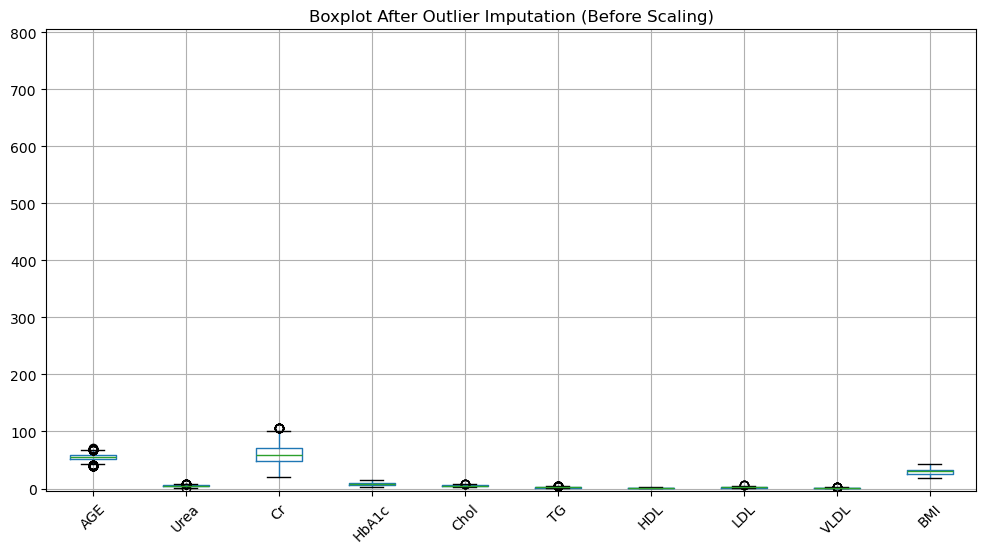

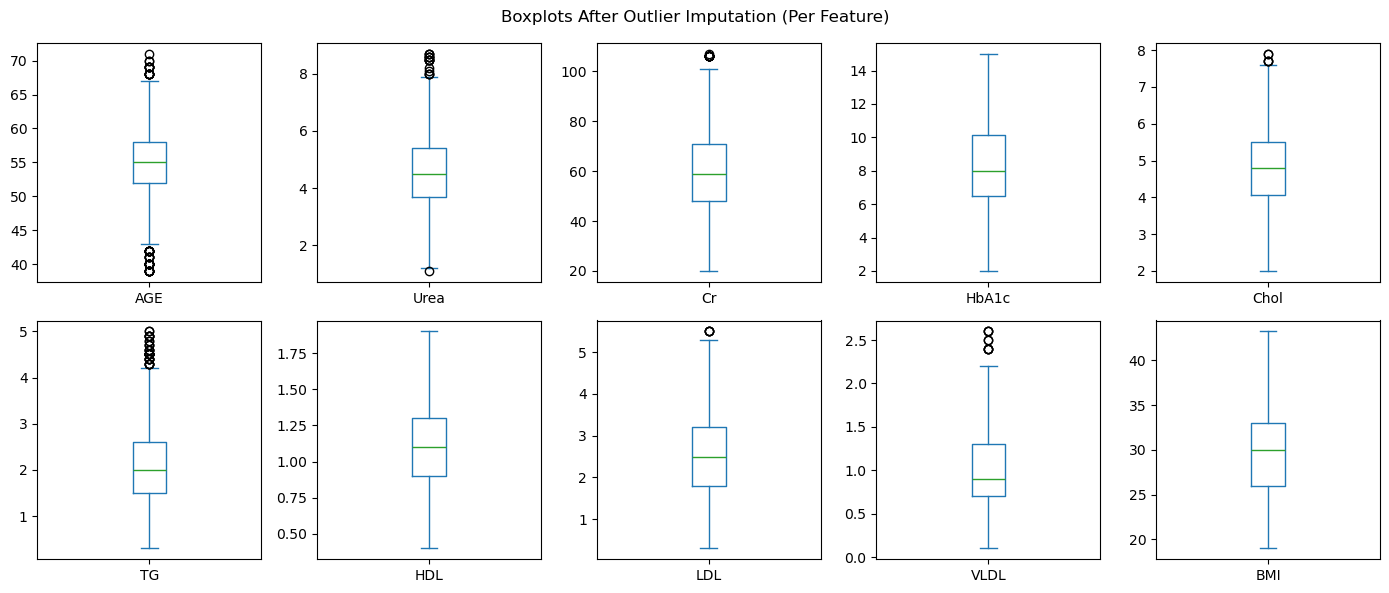

In [15]:
#######################################Scatter plots after removing outliers#######################################

#visualizing after removing outliers
plt.figure(figsize=(12,6))
df_cleaned[num_col].boxplot()
plt.title("Boxplot After Outlier Imputation (Before Scaling)")
plt.ylim(ymin, ymax)  # same y scale as 'before'
plt.xticks(rotation=45)
plt.savefig("visualization/Boxplot_after_outlier_imputation.png", dpi=300, bbox_inches='tight')
plt.show()

# Subplots for each numeric column
df_cleaned[num_col].plot.box(
    subplots=True,
    layout=(2, 5),
    figsize=(14, 6),
    sharey=False,
    title='Boxplots After Outlier Imputation (Per Feature)'
)
plt.tight_layout()
plt.savefig("visualization/Boxplot_after_outlier_imputation_subplots.png", dpi=300, bbox_inches='tight')
plt.show()


## Step 12 B: Scatter Plots After Outlier Imputation


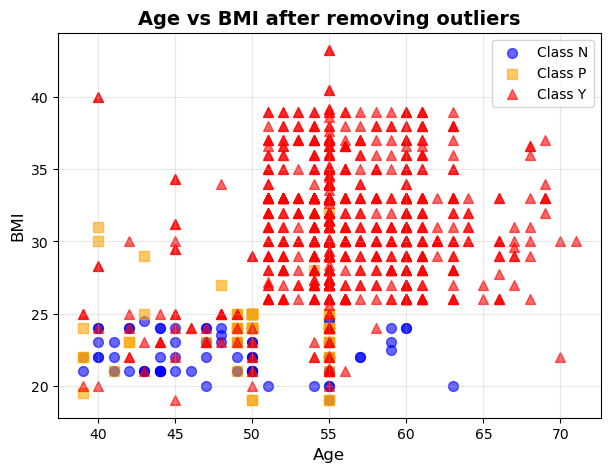

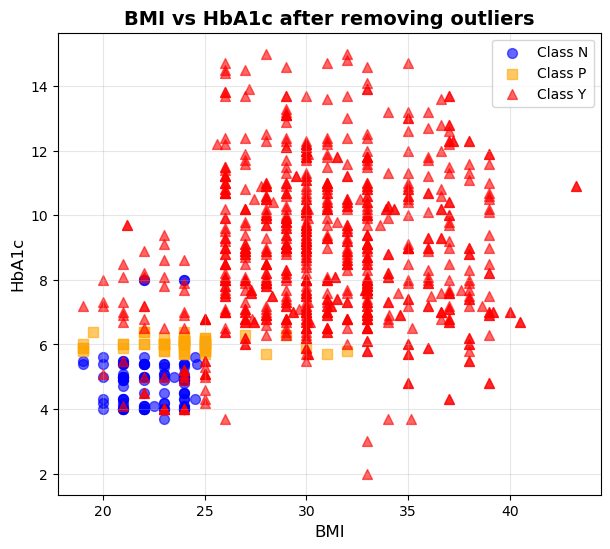

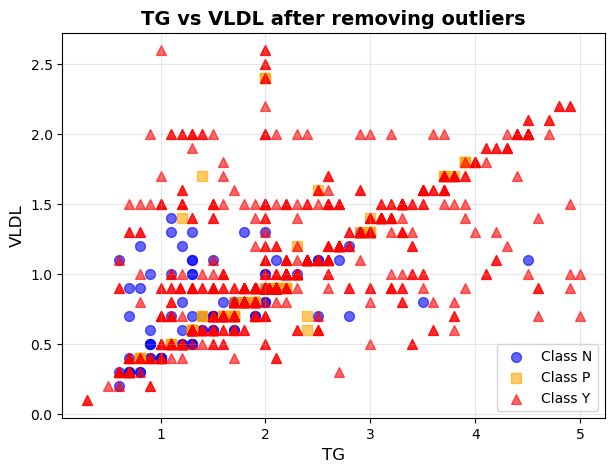

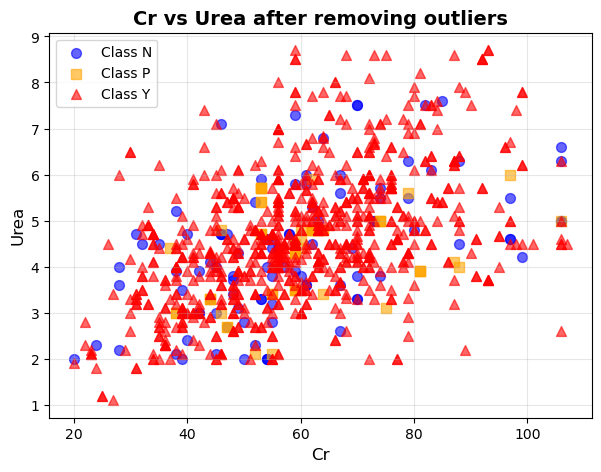

In [16]:
#Scatter plots after removing outliers
# Age vs BMI
plt.figure(figsize=(7, 5))
for dclass, color, marker in zip(['N', 'P', 'Y'], ['blue', 'orange', 'red'], ['o', 's', '^']):
    subset = df_cleaned[df_cleaned['CLASS_original'] == dclass]
    plt.scatter(subset['AGE'], subset['BMI'], 
                alpha=0.6, c=color, label=f'Class {dclass}', 
                marker=marker, s=50)

plt.xlabel('Age', fontsize=12)
plt.ylabel('BMI', fontsize=12)
plt.title('Age vs BMI after removing outliers', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("visualization/Age_vs_BMI_after_outliers.png", dpi=300, bbox_inches='tight')
plt.show()

# BMI vs HbA1c
plt.figure(figsize=(7, 6))
for dclass, color, marker in zip(['N', 'P', 'Y'], ['blue', 'orange', 'red'], ['o', 's', '^']):
    subset = df_cleaned[df_cleaned['CLASS_original'] == dclass]
    plt.scatter(subset['BMI'], subset['HbA1c'], 
                alpha=0.6, c=color, label=f'Class {dclass}', 
                marker=marker, s=50)

plt.xlabel('BMI', fontsize=12)
plt.ylabel('HbA1c', fontsize=12)
plt.title('BMI vs HbA1c after removing outliers', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("visualization/BMI_vs_HbA1c_after_outliers.png", dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(7, 5))
for dclass, color, marker in zip(['N', 'P', 'Y'], ['blue', 'orange', 'red'], ['o', 's', '^']):
    subset = df_cleaned[df_cleaned['CLASS_original'] == dclass]
    plt.scatter(subset['TG'], subset['VLDL'],
                alpha=0.6, c=color, label=f'Class {dclass}', marker=marker, s=50)

plt.xlabel('TG', fontsize=12)
plt.ylabel('VLDL', fontsize=12)
plt.title('TG vs VLDL after removing outliers', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("visualization/TG_vs_VLDL_after_outliers.png", dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(7, 5))
for dclass, color, marker in zip(['N', 'P', 'Y'], ['blue', 'orange', 'red'], ['o', 's', '^']):
    subset = df_cleaned[df_cleaned['CLASS_original'] == dclass]
    plt.scatter(subset['Cr'], subset['Urea'],
                alpha=0.6, c=color, label=f'Class {dclass}', marker=marker, s=50)

plt.xlabel('Cr', fontsize=12)
plt.ylabel('Urea', fontsize=12)
plt.title('Cr vs Urea after removing outliers', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("visualization/Cr_vs_Urea_after_outliers.png", dpi=300, bbox_inches='tight')
plt.show()
#######################################Scatter plots after removing outliers#######################################


## Step 13: Scale and Visualize Final Features


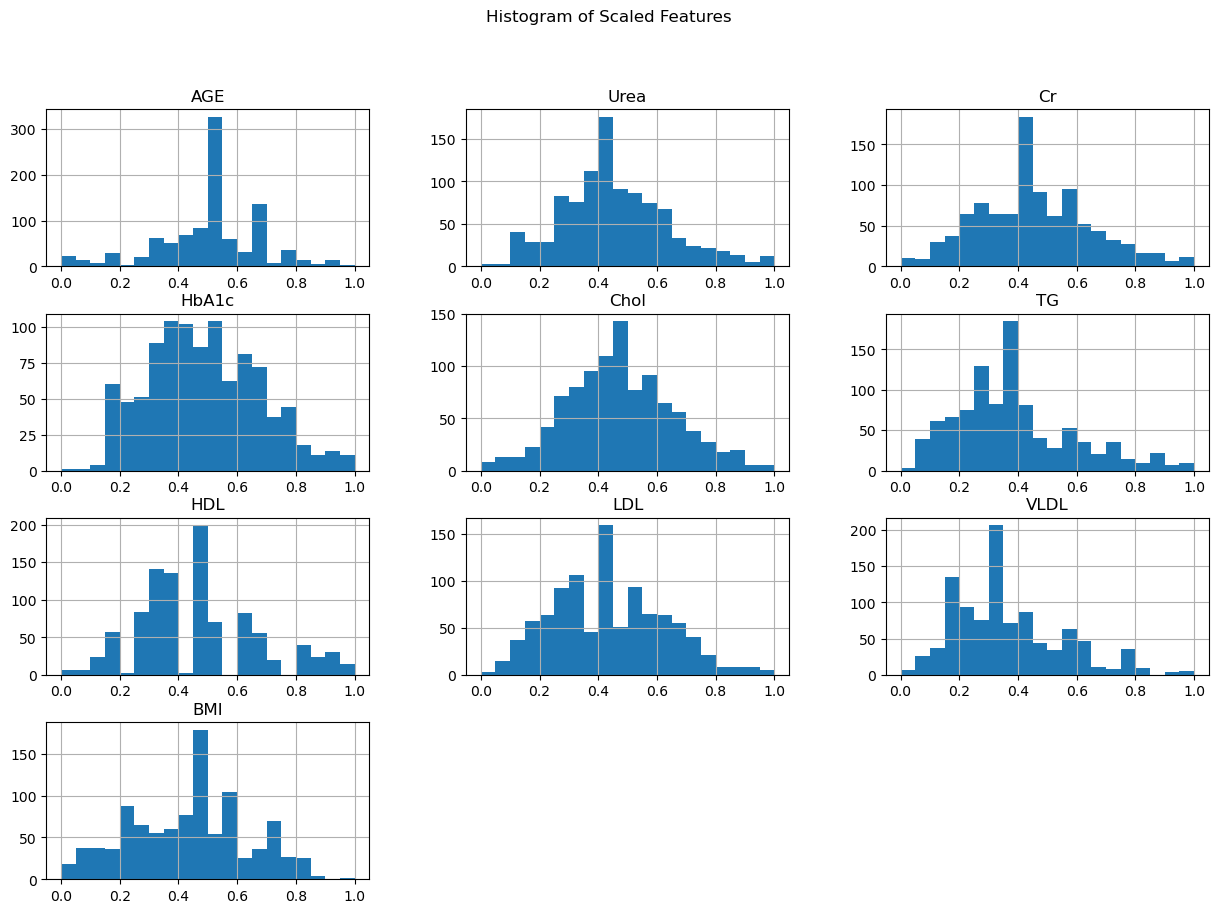

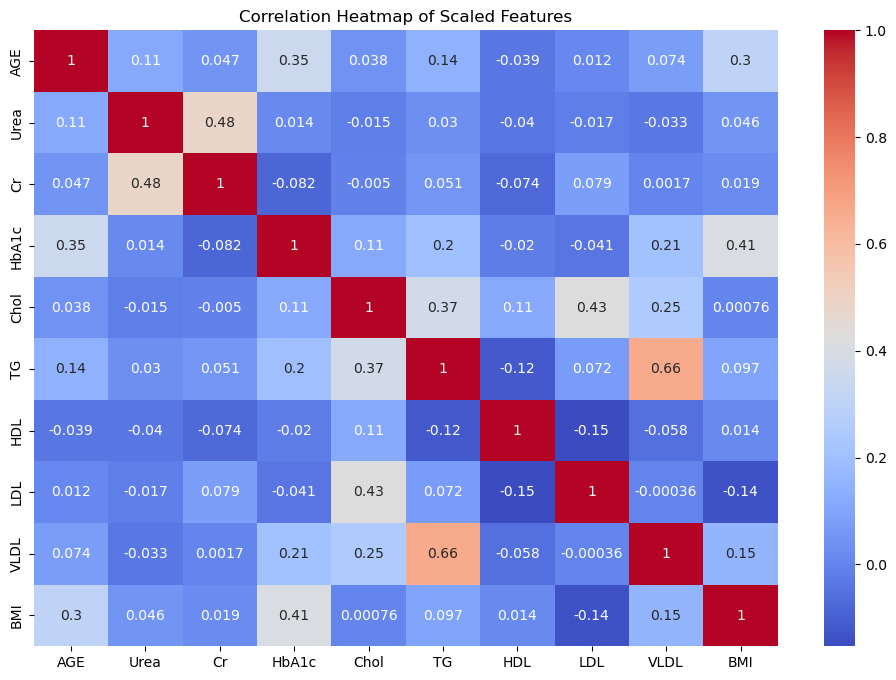

In [17]:
#now scaling
scaler=MinMaxScaler()
df_cleaned[num_col] = scaler.fit_transform(df_cleaned[num_col])
df_cleaned[num_col].describe()

df_cleaned[num_col].hist(bins=20, figsize=(15,10))
plt.suptitle("Histogram of Scaled Features")
plt.savefig("visualization/Histogram_scaled_features.png", dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(12,8))
sns.heatmap(df_cleaned[num_col].corr(method='spearman'), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Scaled Features")
plt.savefig("visualization/Correlation_heatmap_scaled_features.png", dpi=300, bbox_inches='tight')
plt.show()


### Step 14: Data Splitting

In [18]:
from sklearn.model_selection import train_test_split


#data splitting
# Target column (the original version before one-hot encoding)
y = df_cleaned['CLASS_original']

# Feature set (numerical + encoded gender)
X = df_cleaned[num_col]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (800, 10)
Testing data shape: (200, 10)


### Logistic Regression Model

In [ ]:
logRegModel= LogisticRegression()
logRegModel.fit(X_train, y_train)

y_pred = logRegModel.predict(X_test) # Predict class labels
y_proba = logRegModel.predict_proba(X_test) # Predict class probabilities

precision = metrics.precision_score(y_test, y_pred,  average='weighted')
recall = metrics.recall_score(y_test, y_pred,  average='weighted')
accuracy = metrics.accuracy_score(y_test, y_pred) * 100
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Accuracy: {accuracy:.2f}%" )
print("Confusion Matrix:\n", confusion_matrix )

# Plot
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
disp.plot(cmap='Blues', values_format='d')

plt.title("Confusion Matrix")
plt.show()

Precision: 0.86
Recall: 0.91
Accuracy: 90.50%
Confusion Matrix:
 [[ 13   1   7]
 [  3   0   7]
 [  1   0 168]]


TypeError: ConfusionMatrixDisplay.__init__() missing 1 required positional argument: 'confusion_matrix'